In [1]:
import sys
import os
directory = os.path.abspath(os.path.join('..'))
sys.path.append(directory)
import numpy as np
from matplotlib import pyplot as plt
from scripts.model_params import *
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scripts.cell_model_fedbatch import *
import sksundae as sun
import pandas as pd
from scripts.fedbatch_culture_simulation import *
import joblib
from pathlib import Path
import os
import time

Defining and importing base parameters

In [2]:
# defining parameters
sS0 = 0.5; cultvol = 1.25 #quality of the nutrients and volume of the culture
vX = 726; kX = 1e3 # X export parameters
tmax = 2000; runintmax = 1e6 #simulation time parameters

N0  = 1e6
xS0 = ((10*cultvol)/180)*6.02e23; # amount of glucose in media = 10g/L in 1.25L working vol in 3L vessel
M0 = 1e8 

Defining the system topology parameters

In [3]:
#choosing the product transport method. 1 indicates this method is included
lin_trans      = 1
Tp_trans       = 0
T_trans        = 0
diff_trans     = 0

#mutaually exclusive; only one of these can be 1, rest must be 0
eprodtox       = 1
elongationtox  = 0

topology = [lin_trans, Tp_trans, T_trans, diff_trans, eprodtox, elongationtox]

creating the host and engineered parameter arrays

In [4]:
xS_thresh = xS0
base_params = [xS0, xS_thresh, runintmax, tmax, N0, topology]

hPR0, xPR0 = model_params(sS0, vX, kX, cultvol, leaky_control=False)
hPR = np.array(hPR0)
xPR = np.array(xPR0)
# 0     1       2       3       4         5        6        7           8
#[w0,   wE,     wEp,    wTF,    wpTox,    wTp,     k_Ep,    Km_Ep,      k_Tp,
#   9      10             11                 12
# # Km_Tp, a_energy_pTox, a_elongation_pTox, K_E, 
#   13      14      15       16       17   18
# # K_pTox, kdiffP, VolCell, VolCult, ksf, ksr]

Setting specific circuit parameters

In [5]:
wE = 20; wEp = 20; wTF = 20; wpTox = 2;
K_E = 0.3; K_pTox = 1.0

xPR[[1, 2, 3, 4, 12, 13]] = [wE, wEp, wTF, wpTox, K_E, K_pTox]

Running the exact simulation

In [6]:
T , Y = fedbatch_cult_sim(base_params, hPR, xPR, integration_method="BDF", plot=False, rtol=1E-6, atol=1E-9)

steady state found


Plotting pre induction

Text(0, 0.5, 'External Product')

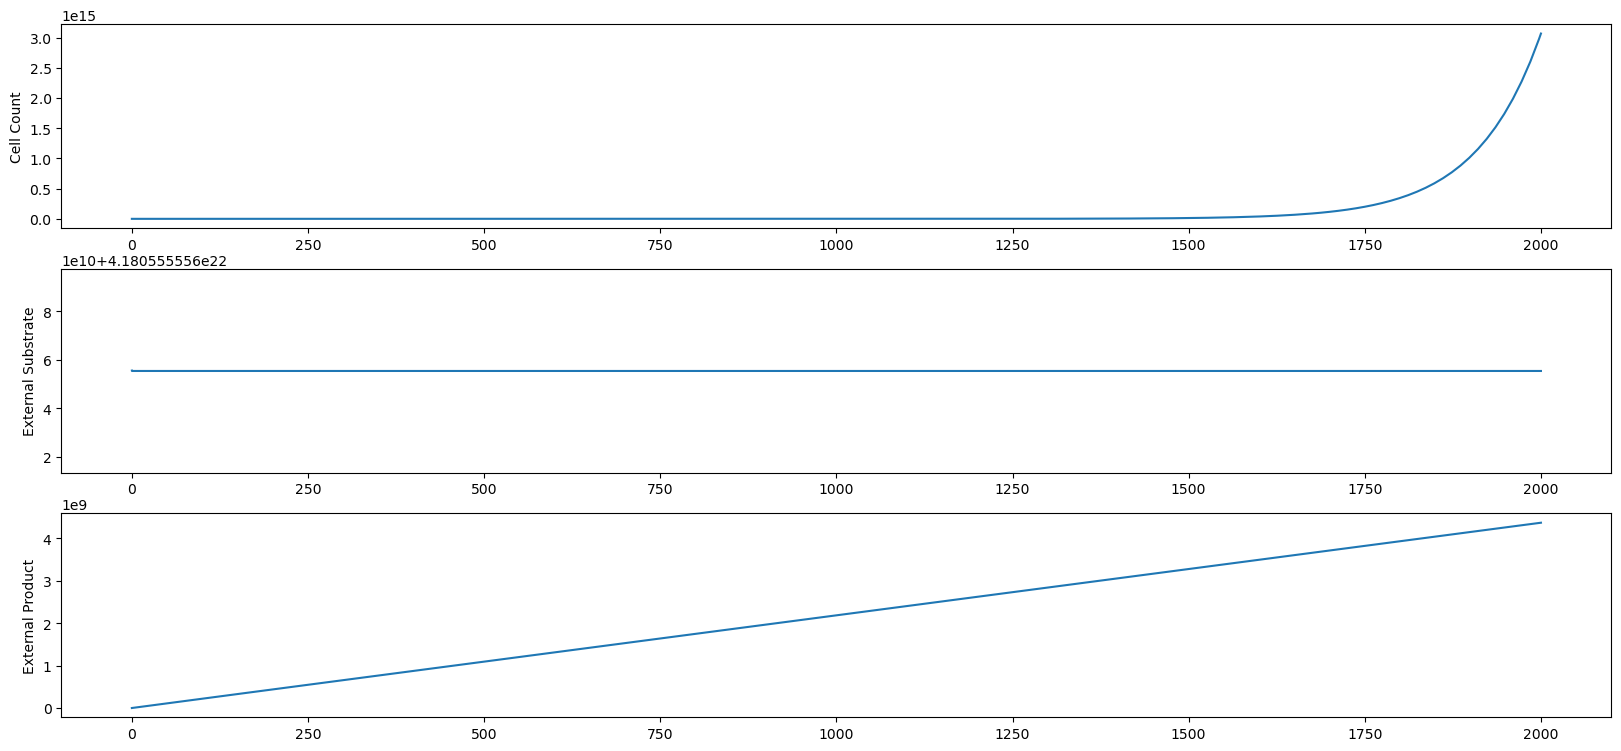

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(20, 9))
axs[0].plot(T, Y[0])
axs[0].set_ylabel("Cell Count")
axs[1].plot(T, Y[1])
axs[1].set_ylabel("External Substrate")
axs[2].plot(T, Y[2])
axs[2].set_ylabel("External Product")

Plotting the internal product over time

Text(0.5, 0, 'Time (minutes)')

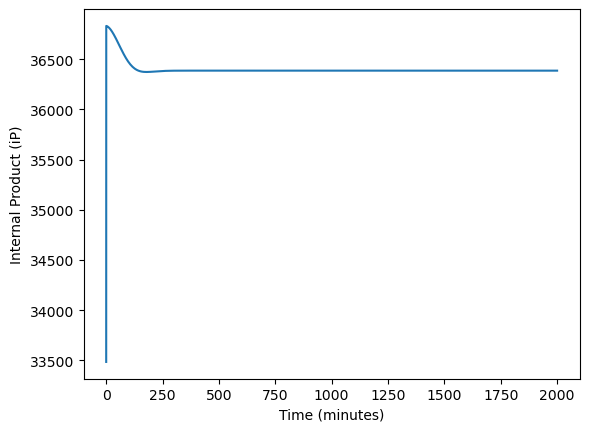

In [8]:
plt.plot(T, Y[22])
plt.ylabel("Internal Product (iP)")
plt.xlabel("Time (minutes)")

Plotting the transcription factor and its product dimer over time

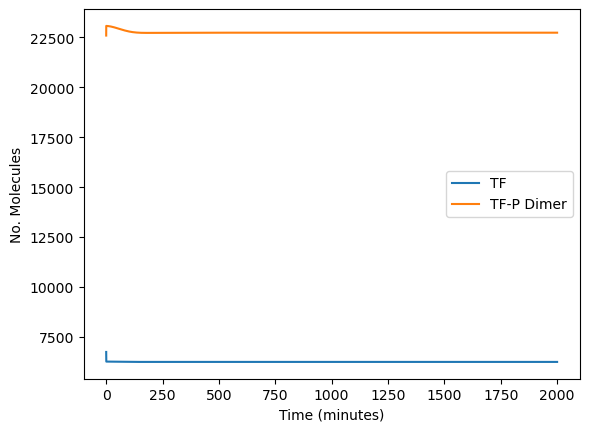

In [9]:
plt.plot(T, Y[25], label="TF")
plt.plot(T, Y[26], label="TF-P Dimer")
plt.ylabel("No. Molecules")
plt.xlabel("Time (minutes)")
plt.legend()

Plotting E over time

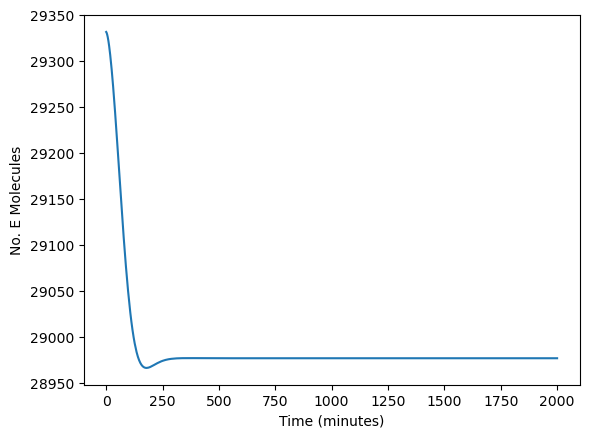

In [10]:
fig, ax = plt.subplots()
ax.plot(T, Y[10])
plt.xlabel("Time (minutes)")
plt.ylabel("No. E Molecules")
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

Plotting pTox over time

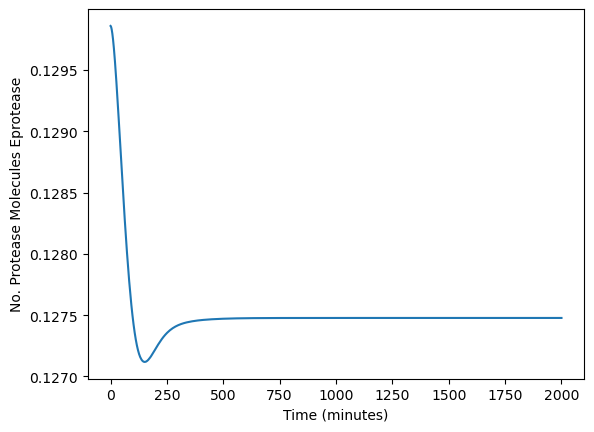

In [11]:
fig, ax = plt.subplots()
ax.plot(T, Y[29])
plt.xlabel("Time (minutes)")
plt.ylabel("No. Protease Molecules Eprotease")
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

Ep

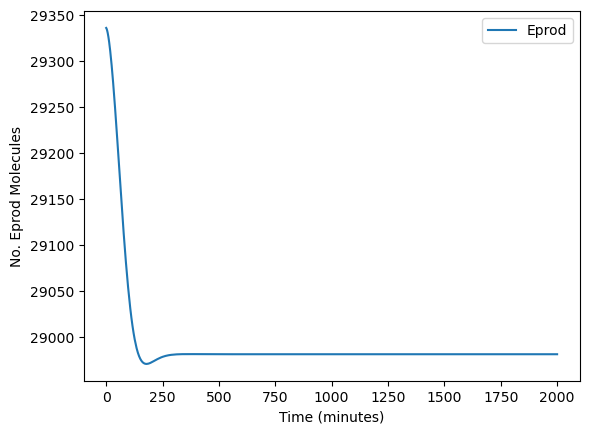

In [12]:
fig, ax = plt.subplots()
ax.plot(T, Y[21], label="Eprod")
plt.xlabel("Time (minutes)")
plt.ylabel("No. Eprod Molecules")
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.legend()

Plotting the number of active ribosomes over time

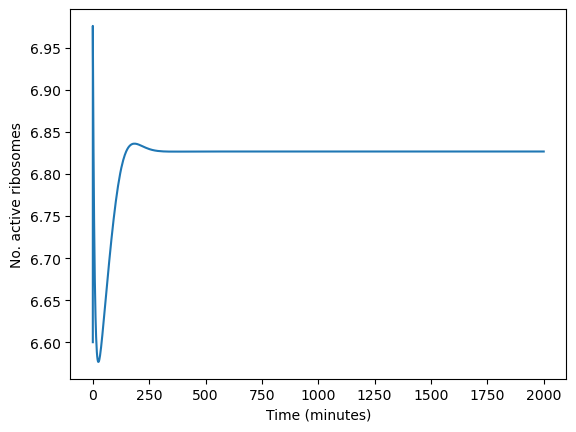

In [13]:
fig, ax = plt.subplots()
ax.plot(T, Y[18])
plt.xlabel("Time (minutes)")
plt.ylabel("No. active ribosomes")
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)